# Project task 02: Restaurant recommendation

In [2]:
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge
import time
import random
from sklearn.model_selection import ParameterGrid

The goal of this task is to recommend restaurants to users based on the rating data in the Yelp dataset. For this, we try to predict the rating a user will give to a restaurant they have not been to yet based on a latent factor model.

## 1. Load data

First download `ratings.npy` from Piazza ([download link](https://syncandshare.lrz.de/dl/fiKMoxRNusLoFpFHkXXEgvdZ/ratings.npy)).

In [3]:
ratings = np.load("ratings.npy")

In [4]:
# We have triplets of (user, restaurant, rating).
ratings

array([[101968,   1880,      1],
       [101968,    284,      5],
       [101968,   1378,      2],
       ...,
       [ 72452,   2100,      4],
       [ 72452,   2050,      5],
       [ 74861,   3979,      5]], dtype=uint32)

Now we transform the data into a matrix of dimension [N, D], where N is the number of users and D is the number of restaurants in the dataset.  
We **strongly recommend** to load the data as a sparse matrix to avoid out-of-memory issues.

In [5]:
# Store the matrix into the variable M
M = sp.csr_matrix((ratings[:,2], (ratings[:,0], ratings[:,1])),dtype=np.float64)

In [6]:
M

<337867x5899 sparse matrix of type '<class 'numpy.float64'>'
	with 929606 stored elements in Compressed Sparse Row format>

## 2. Preprocess the data

In the preprocessing step, we recursively remove all users and restaurants with 10 or less ratings. 

Then, we randomly select 200 data points for the validation and test sets, respectively.

After this, we subtract the mean rating for each users to account for this global effect.   
**Hint**: Some entries might become zero in this process -- but these entries are different than the 'unknown' zeros in the matrix. Store the indices of which we have data available in a separate variable.

In [7]:
def cold_start_preprocessing(matrix, min_entries):
    """
    Recursively removes rows and columns from the input matrix which have less than min_entries nonzero entries.
    
    Parameters
    ----------
    matrix      : sp.spmatrix, shape [N, D]
                  The input matrix to be preprocessed.
    min_entries : int
                  Minimum number of nonzero elements per row and column.

    Returns
    -------
    matrix      : sp.spmatrix, shape [N', D']
                  The pre-processed matrix, where N' <= N and D' <= D
        
    """
    print("Shape before: {}".format(matrix.shape))
    
    # Calculating binary values for each row an column
    rows = matrix.getnnz(1)>min_entries
    cols = matrix.getnnz(0)>min_entries
    
    # If any value of binary vector has False in it, delete rows/cols that have False value
    while (not rows.all()) or (not cols.all()):
        matrix = matrix[rows][:,cols]
        rows = matrix.getnnz(1)>min_entries
        cols = matrix.getnnz(0)>min_entries

        
    print("Shape after: {}".format(matrix.shape))
    nnz = matrix>0
    assert (nnz.sum(0).A1 > min_entries).all()
    assert (nnz.sum(1).A1 > min_entries).all()
    return matrix

In [8]:
def shift_user_mean(matrix):
    """
    Subtract the mean rating per user from the non-zero elements in the input matrix.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             Input sparse matrix.
    Returns
    -------
    matrix : sp.spmatrix, shape [N, D]
             The modified input matrix.
    
    user_means : np.array, shape [N, 1]
                 The mean rating per user that can be used to recover the absolute ratings from the mean-shifted ones.

    """
    rows, cols = np.nonzero(matrix)
    user_means = np.zeros((matrix.shape[0], 1))
    for i in range(matrix.shape[0]):
        if matrix[i].count_nonzero() > 0:
            user_means[i] = matrix[i].sum()/matrix[i].count_nonzero()
        else:
            user_means[i] = 0
    for i, row in enumerate(rows):
        matrix[row, cols[i]] -= user_means[row]

    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, user_means

In [9]:
def split_data(matrix, n_validation, n_test):
    """
    Extract validation and test entries from the input matrix. 
    
    Parameters
    ----------
    matrix          : sp.spmatrix, shape [N, D]
                      The input data matrix.
    n_validation    : int
                      The number of validation entries to extract.
    n_test          : int
                      The number of test entries to extract.

    Returns
    -------
    matrix_split    : sp.spmatrix, shape [N, D]
                      A copy of the input matrix in which the validation and test entries have been set to zero.
    
    val_idx         : tuple, shape [2, n_validation]
                      The indices of the validation entries.
    
    test_idx        : tuple, shape [2, n_test]
                      The indices of the test entries.
    
    val_values      : np.array, shape [n_validation, ]
                      The values of the input matrix at the validation indices.
                      
    test_values     : np.array, shape [n_test, ]
                      The values of the input matrix at the test indices.

    """
    # Generating indices of nonzero entries
    rows, cols = np.nonzero(matrix)
    # Generatin random rows
    rand_items = np.random.choice(rows.shape[0], n_validation+n_test, replace=False)
    val_idx = (rows[rand_items[:n_validation]], cols[rand_items[:n_validation]])    
    test_idx = (rows[rand_items[n_validation:]], cols[rand_items[n_validation:]]) 
    val_values = matrix[val_idx]
    test_values = matrix[test_idx]
    matrix_split = matrix.copy()
    matrix_split[val_idx] = 0
    matrix_split[test_idx] = 0
    matrix_split.eliminate_zeros()
    return matrix_split, val_idx, test_idx, val_values, test_values

In [10]:
M = cold_start_preprocessing(M, 10)
#Shape before: (337867, 5899)
#Shape after: (11275, 3531)
L = M.copy()

Shape before: (337867, 5899)
Shape after: (11275, 3531)


In [11]:
n_validation = 200
n_test = 200
# Split data
M_train, val_idx, test_idx, val_values, test_values = split_data(M, n_validation, n_test)

In [12]:
# Store away the nonzero indices of M before subtracting the row means.
nonzero_indices = np.nonzero(M_train)
# Remove user means.
M_shifted, user_means = shift_user_mean(M_train)
# Apply the same shift to the validation and test data.
val_values_shifted = val_values - user_means[val_idx[0]].T 
test_values_shifted = test_values - user_means[test_idx[0]].T 

In [13]:
M_n_shifted, _ = shift_user_mean(M)

In [14]:
print(np.max(L))

5.0


## 3. Alternating optimization

In the first step, we will approach the problem via alternating optimization, as learned in the lecture.

In [23]:
def initialize_Q_P(matrix, k, init='random'):
    """
    Initialize the matrices Q and P for a latent factor model.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             The matrix to be factorized.
    k      : int
             The number of latent dimensions.
    init   : str in ['svd', 'random'], default: 'random'
             The initialization strategy. 'svd' means that we use SVD to initialize P and Q, 
             'random' means we initialize the entries in P and Q randomly in the interval [0, 1).

    Returns
    -------
    Q : np.array, shape [N, k]
        The initialized matrix Q of a latent factor model.

    P : np.array, shape [k, D]
        The initialized matrix P of a latent factor model.
    """

    N, D = matrix.shape
    if init == 'svd':  
        Q, _, P = svds(matrix, k=k)
    elif init == 'random':
        Q = np.random.random((N, k))
        P = np.random.random((k, D))
    else:
        raise ValueError
        
    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P

In [24]:
def latent_factor_alternating_optimization(M, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=10, eval_every=1):
    """
    Perform matrix factorization using alternating optimization. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.
                      
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.

    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """

    Q, P = initialize_Q_P(M, k, init)
    
    N = M.shape[0]
    D = P.shape[1]

    item2nzusers = {}
    user2nzitems = {}
    converged_after = 0
    for (u, i) in np.array(non_zero_idx).T:
        if i not in item2nzusers:
            item2nzusers[i] = []
        item2nzusers[i].append(u)
      
        if u not in user2nzitems:
            user2nzitems[u] = []
        user2nzitems[u].append(i)
          
    best_Q = Q
    best_P = P
    train_losses = []
    validation_losses = []
    lr = Ridge(alpha = reg_lambda)
    curr_patience = patience
    zero_time = time.time()
    start_time = time.time()
    best_val_loss = 0
    for iteration in range(max_steps):        
        
        if iteration % eval_every == 0:
            QP = Q.dot(P)
            train_losses.append(np.sum(np.square(M[non_zero_idx] - QP[non_zero_idx])))
            validation_losses.append(np.sum(np.square(val_values - QP[val_idx])))
            if iteration == 0 or best_val_loss > validation_losses[-1]:
                best_Q = Q
                best_P = P
                best_val_loss = validation_losses[-1]
                curr_patience = patience
                converged_after = iteration 
            else:
                curr_patience -= 1
      
        if iteration % log_every == 0:
            print("Iteration {:}, training loss: {:.2f}, validation loss = {:.2f}, time = {:.2f}".
                  format(iteration, train_losses[-1], validation_losses[-1], time.time()-start_time))
            start_time = time.time()
            
        for d in range(D):
            nzusers = item2nzusers[d]
            P[:, d] = lr.fit(X=Q[nzusers,:], y=M[nzusers, d].toarray()).coef_

        for u in range(N):
            nzitems = user2nzitems[u]
            Q[u, :] = lr.fit(X=P[:,nzitems].T,
                             y=M[u, nzitems].toarray().T).coef_
            
        if curr_patience == 0 or max_steps==iteration:
            break
            
    print("Converged after {:} iterations, on average {:.2f} per iteration".
          format(converged_after, (time.time() - zero_time)/iteration))
    return best_Q, best_P, validation_losses, train_losses, converged_after


#### Train the latent factor model with alternating optimization.

a) Learn the optimal $P$ and $Q$ using alternating optimization. That is, during each iteration you first update $Q$ while having $P$ fixed and then vice versa. Run the alternating optimization algorithm with $k=100$ and $\lambda=1$. Plot the training and validation losses over time.

In [25]:
Q_a, P_a, val_l_a, tr_l_a, conv_a = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=100, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=1, init='random',
                                                                           max_steps=100, patience=10)

Iteration 0, training loss: 179994070.47, validation loss = 124779.84, time = 0.51
Iteration 1, training loss: 31409.57, validation loss = 291.93, time = 23.23
Iteration 2, training loss: 11182.24, validation loss = 285.26, time = 20.60
Iteration 3, training loss: 8219.73, validation loss = 266.29, time = 18.69
Iteration 4, training loss: 7204.58, validation loss = 253.78, time = 18.18
Iteration 5, training loss: 6715.96, validation loss = 247.71, time = 18.57
Iteration 6, training loss: 6434.72, validation loss = 245.86, time = 19.08
Iteration 7, training loss: 6253.53, validation loss = 246.46, time = 18.77
Iteration 8, training loss: 6126.62, validation loss = 247.95, time = 18.56
Iteration 9, training loss: 6032.11, validation loss = 249.36, time = 18.31
Iteration 10, training loss: 5958.34, validation loss = 250.38, time = 18.67
Iteration 11, training loss: 5898.63, validation loss = 251.02, time = 17.51
Iteration 12, training loss: 5848.99, validation loss = 251.33, time = 17.71


#### Plot the validation and training losses over (training) time

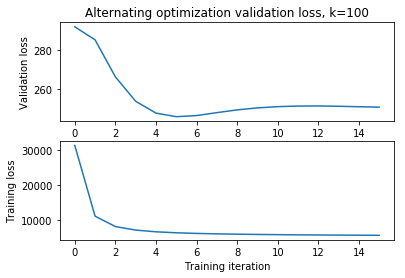

In [26]:
plt.subplot(2, 1, 1)
plt.plot(val_l_a[1:])
plt.title('Alternating optimization validation loss, k=100')
plt.xlabel('Training iteration')
plt.ylabel('Validation loss')

plt.subplot(2, 1, 2)
plt.plot(tr_l_a[1:])
plt.xlabel('Training iteration')
plt.ylabel('Training loss')

plt.show()

b) (**Optional**): Try some different latent dimensions $k$ in the range [5, 100]. What do you observe (convergence time, final training/validation losses)?

In [27]:
Q_a_2, P_a_2, val_l_a_2, tr_l_a_2, conv_a_2 = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=6, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=0.1, init='random',
                                                                           max_steps=100, patience=10)

Iteration 0, training loss: 1084730.81, validation loss = 695.84, time = 0.26
Iteration 1, training loss: 235522.05, validation loss = 504.90, time = 16.59
Iteration 2, training loss: 214614.64, validation loss = 515.43, time = 16.41
Iteration 3, training loss: 205248.79, validation loss = 474.89, time = 16.43
Iteration 4, training loss: 199781.70, validation loss = 452.45, time = 17.70
Iteration 5, training loss: 196144.97, validation loss = 436.49, time = 17.08
Iteration 6, training loss: 193547.23, validation loss = 425.16, time = 16.20
Iteration 7, training loss: 191597.89, validation loss = 418.99, time = 16.25
Iteration 8, training loss: 190061.34, validation loss = 415.77, time = 15.67
Iteration 9, training loss: 188813.93, validation loss = 413.78, time = 15.48
Iteration 10, training loss: 187763.58, validation loss = 413.46, time = 15.78
Iteration 11, training loss: 186854.34, validation loss = 415.16, time = 15.74
Iteration 12, training loss: 186066.08, validation loss = 421.

#### Plot the validation and training losses over (training) time

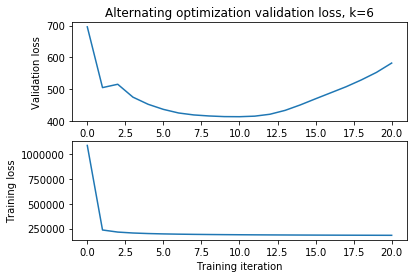

In [28]:
plt.subplot(2, 1, 1)
plt.plot(val_l_a_2[:])
plt.title('Alternating optimization validation loss, k=6')
plt.xlabel('Training iteration')
plt.ylabel('Validation loss')

plt.subplot(2, 1, 2)
plt.plot(tr_l_a_2[:])
plt.xlabel('Training iteration')
plt.ylabel('Training loss')

plt.show()


## 4. Latent factorization using gradient descent

We now use gradient descent to factorize our ratings matrix. We will try both (mini-) batch and stochastic gradient descent. You can use the following equations for your implementation.

Recall that the objective function (loss) we wanted to optimize was:
$$
\mathcal{L} = \min_{P, Q} \sum_{(x, i) \in W} (r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2 + \lambda_1\sum_x{\left\lVert \mathbf{p}_x  \right\rVert}^2 + \lambda_2\sum_i {\left\lVert\mathbf{q}_i  \right\rVert}^2
$$

where $W$ is the set of $(x, i)$ pairs for which $r_{xi}$ is known (in this case our known play counts). Here we have also introduced two regularization terms to help us with overfitting where $\lambda_1$ and $\lambda_2$ are hyper-parameters that control the strength of the regularization.

Naturally optimizing with gradient descent involves computing the gradient of the loss function $\mathcal{L}$ w.r.t. to the parameters. To help you solve the task we provide the following:

$$
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{p}_x} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{q}_i\;, ~~~
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{q}_i} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{p}_x 
$$

$$
\frac{\partial(\lambda_1{\left\lVert \mathbf{p}_x \right\rVert}^2)}{\partial \mathbf{p}_x} = 2 \lambda_1 \mathbf{p_x} \;, ~~~
\frac{\partial(\lambda_2{\left\lVert \mathbf{q}_i \right\rVert}^2)}{\partial \mathbf{q}_i} = 2 \lambda_2 \mathbf{q_i}
$$

**Hint**: You have to carefully consider how to combine the given partial gradients depending
on which variants of gradient descent you are using.  
**Hint 2**: It may be useful to scale the updates to $P$ and $Q$ by $\frac{1}{batch\_size}$ (in the case of full-sweep updates, this would be $\frac{1}{n\_users}$ for $Q$ and $\frac{1}{n\_restaurants}$ for $P$).


For each of the gradients descent variants you try report and compare the following:
* How many iterations do you need for convergence.
* Plot the loss (y axis) for each iteration (x axis).


In [31]:
def latent_factor_gradient_descent(M, non_zero_idx, k, val_idx, val_values, 
                                   reg_lambda, learning_rate, batch_size=-1,
                                   max_steps=50000, init='random',
                                   log_every=1000, patience=20,
                                   eval_every=50):
    """
    Perform matrix factorization using gradient descent. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.

    learning_rate     : float
                        Step size of the gradient descent updates.
                        
    batch_size        : int, optional, default: -1
                        (Mini-) batch size. -1 means we perform standard full-sweep gradient descent.
                        If the batch size is >0, use mini batches of this given size.
                        
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.
                        
    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """
       
    Q, P = initialize_Q_P(M, k, init)
    
    N = M.shape[0]
    D = P.shape[1]
    
    converged_after = 0        
    step_array = np.arange(batch_size, N, batch_size)
    best_Q = Q
    best_P = P
    P_new = np.zeros(P.shape)
    Q_new = np.zeros(Q.shape)
    train_losses = []
    validation_losses = []
    curr_patience = patience
    zero_time = time.time()
    start_time = time.time()
    best_val_loss = 0
    
    step_array_N = []
    step_array_D= []
    lowest_border = 0
    batch_size_N = N
    batch_size_D = D
    if batch_size > 0:
        step_array_N = np.arange(batch_size, N, batch_size)
        step_array_D = np.arange(batch_size, D, batch_size)
        batch_size_N = batch_size
        batch_size_D = batch_size
    if N not in step_array_N:
        step_array_N = np.append(step_array_N, N) 
    if D not in step_array_D:
        step_array_D = np.append(step_array_D, D)
    len_d = len(step_array_D)
    len_n = len(step_array_N)
    mult = np.array(nonzero_indices).shape[1]
    for iteration in range(max_steps):        
        
        if iteration % eval_every == 0:
            QP = Q.dot(P)
            train_losses.append(np.sum(np.square(M[non_zero_idx] - QP[non_zero_idx])))
            validation_losses.append(np.sum(np.square(val_values - QP[val_idx])))
            if iteration == 0 or best_val_loss > validation_losses[-1]:
                best_Q = Q
                best_P = P
                best_val_loss = validation_losses[-1]
                curr_patience = patience
                converged_after = iteration 
            else:
                curr_patience -= 1
      
        if iteration % log_every == 0:
            print("Iteration {:}, training loss: {:.2f}, validation loss = {:.2f}, time = {:.2f}".
                  format(iteration, train_losses[-1], validation_losses[-1], time.time()-start_time))
            start_time = time.time() 
            
        if batch_size == -1:   
            diff = (M - Q.dot(P))
            zero_M = np.zeros(M.shape)
            zero_M[non_zero_idx] = diff[non_zero_idx]
            P_new = P + 2 * learning_rate *  (np.dot(Q.T, zero_M) - reg_lambda * P)*N/mult
            Q_new = Q + 2 * learning_rate *  (np.dot(zero_M, P.T) - reg_lambda * Q)*D/mult
            P = P_new
            Q = Q_new
        else:
            rand_items = np.random.choice(mult, batch_size, replace=False)
            for element in rand_items:
                row = non_zero_idx[0][element]
                col = non_zero_idx[1][element]
                diff = M[row, col] - Q[row,:].dot(P[:,col])
                P_new[:,col] = P[:,col]  +  2 * learning_rate *  (Q[row,:].T * diff / batch_size - reg_lambda * P[:,col])
                Q_new[row,:] = Q [row,:] +  2 * learning_rate *  (diff * P[:,col].T / batch_size - reg_lambda * Q[row,:])

                P[:,col] = P_new[:,col]
                Q[row,:]  = Q_new[row,:] 
        if curr_patience == 0 or max_steps==iteration:
            break
    print("Converged after {:} iterations, on average {:.2f} per iteration".
          format(converged_after, (time.time() - zero_time)/iteration))
            
    return best_Q, best_P, validation_losses, train_losses, converged_after

#### Train the latent factor model with alternating optimization.

a) Learn the optimal $P$ and $Q$ using standard gradient descent. That is, during each iteration you have to use all of the training examples and update $Q$ and $P$ for all users and songs at once. Try the algorithm with $k=30$, $\lambda=1$, and learning rate of 0.1. Initialize $Q$ and $P$ with SVD.  

In [32]:
Q_g_sweep, P_g_sweep, val_l_g_sweep, tr_l_g_sweep, conv_g_sweep =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                                   k=30, val_idx=val_idx,
                                                                                                   val_values=val_values_shifted, 
                                                                                                   reg_lambda=1, learning_rate=1e-1,
                                                                                                   init='svd', batch_size=-1,
                                                                                                   max_steps=10000, log_every=20, 
                                                                                                   eval_every=20)

Iteration 0, training loss: 335340.78, validation loss = 213.70, time = 0.23
Iteration 20, training loss: 282253.53, validation loss = 207.33, time = 21.18
Iteration 40, training loss: 193022.47, validation loss = 216.51, time = 21.34
Iteration 60, training loss: 118536.97, validation loss = 233.08, time = 19.65
Iteration 80, training loss: 75682.40, validation loss = 243.33, time = 19.67
Iteration 100, training loss: 53350.07, validation loss = 251.36, time = 19.67
Iteration 120, training loss: 41225.36, validation loss = 258.40, time = 19.28
Iteration 140, training loss: 34113.94, validation loss = 265.13, time = 19.09
Iteration 160, training loss: 29602.46, validation loss = 271.81, time = 20.17
Iteration 180, training loss: 26536.94, validation loss = 278.47, time = 19.14
Iteration 200, training loss: 24332.19, validation loss = 285.05, time = 18.95
Iteration 220, training loss: 22672.06, validation loss = 291.49, time = 19.19
Iteration 240, training loss: 21375.18, validation loss

#### Plot the validation and training losses over (training) time

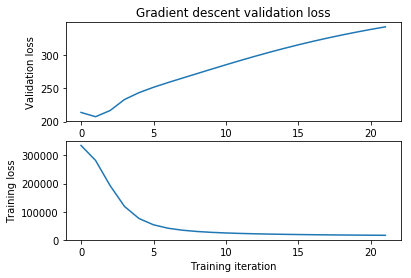

In [33]:
plt.subplot(2, 1, 1)
plt.plot(val_l_g_sweep[:])
plt.title('Gradient descent validation loss')
plt.xlabel('Training iteration')
plt.ylabel('Validation loss')

plt.subplot(2, 1, 2)
plt.plot(tr_l_g_sweep[:])
plt.xlabel('Training iteration')
plt.ylabel('Training loss')

plt.show()



b) Learn the optimal $P$ and $Q$ using the original stochastic gradient descent (mini-batches of size 1). That is, during each iteration you sample a single random training example $r_{xi}$ and update only the respective affected parameters $\mathbf{p_x}$ and $\mathbf{q}_i$. Set the learning rate to 0.01 and keep the other parameters as in a).

In [34]:
Q_g_st, P_g_st, val_l_g_st, tr_l_g_st, conv_g_st = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1e-3, learning_rate=1e-1,
                                                                                   init='svd', batch_size=1,
                                                                                   max_steps=20000, log_every=500, 
                                                                                   eval_every=50)

Iteration 0, training loss: 335340.78, validation loss = 213.70, time = 0.23
Iteration 500, training loss: 335306.06, validation loss = 213.68, time = 7.30
Iteration 1000, training loss: 335271.99, validation loss = 213.69, time = 6.92
Converged after 50 iterations, on average 0.01 per iteration


#### Plot the validation and training losses over (training) time

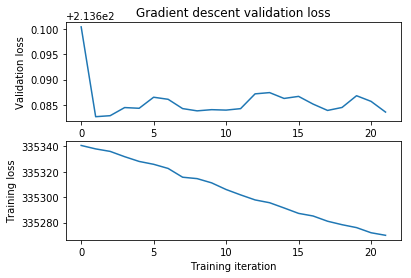

In [35]:

plt.subplot(2, 1, 1)
plt.plot(val_l_g_st[:])
plt.title('Gradient descent validation loss')
plt.xlabel('Training iteration')
plt.ylabel('Validation loss')

plt.subplot(2, 1, 2)
plt.plot(tr_l_g_st[:])
plt.xlabel('Training iteration')
plt.ylabel('Training loss')

plt.show()



c) (**Optional**) Learn the optimal $P$ and $Q$ similarly to b) this time using larger mini-batches of size $S$, e.g. 32.

In [ ]:
Q_g_mb, P_g_mb, val_l_g_mb, tr_l_g_mb, conv_g_mb = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1e-3, learning_rate=1e-1,
                                                                                   init='svd', batch_size=32,
                                                                                   max_steps=10000, log_every=100, 
                                                                                   eval_every=50)

#### Plot the validation and training losses over (training) time

In [ ]:

plt.subplot(2, 1, 1)
plt.plot(val_l_g_st[:])
plt.title('Gradient descent validation loss')
plt.xlabel('Training iteration')
plt.ylabel('Validation loss')

plt.subplot(2, 1, 2)
plt.plot(tr_l_g_st[:])
plt.xlabel('Training iteration')
plt.ylabel('Training loss')

plt.show()


### 4.5 Hyperparameter search

Machine learning models are often heavily dependent on the hyperparameter settings, e.g. the learning rate. Here, we will try a simple random search to find good values of the latent factor dimension $k$, the batch size, learning rate, and regularization.  

### Tasks:

Perform a hyperparameter search to find good values for the batch size, lambda, learning rate, and latent dimension. 

* For the batch size, evaluate all values in [1, 32, 512, -1] (-1 corresponds to full-sweep gradient descent).
* For $\lambda$, randomly sample three values in the interval [0, 1).
* For the learning rate, evaluate all values in [1, 0.1, 0.01].
* For the latent dimension, uniformly sample three values in the interval [5,30].

Perform an exhaustive search among all combinations of these values;

**Hint**: This may take a while to compute. **You don't have to wait for all the models to train** -- simply use "dummy" code instead of actual model training (or let it train, e.g., for only one iteration) if you don't want to wait. Note that the signature of this dummy code has to match the function 'latent_factor_gradient_descent' so that we could simply plug in the actual function.



In [36]:
def parameter_search(M_train, val_idx, val_values):
    """
    Hyperparameter search using random search.
    
    Parameters
    ----------
    
    M_train     : sp.spmatrix, shape [N, D]
                  Input sparse matrix where the user means have not
                  been subtracted yet. 
                  
    val_idx     : tuple, shape [2, n_validation]
                  The indices used for validation, where n_validation
                  is the size of the validation set.
                  
    val_values  : np.array, shape [n_validation, ]
                  Validation set values, where n_validation is the
                  size of the validation set.

    Returns
    -------
    best_conf   : tuple, (batch_size, lambda, learning_rate, latent_dimension)
                  The best-performing hyperparameters.
                  

    """
    
    ### YOUR CODE HERE ###  
    
    param_grid = {
          'batch_size': [1, 32, 512, -1],
          'regularization_param': [random.uniform(0, 1) for i in range(3)],
          'learning_rate': [1, 0.1, 0.01],
          'latent_dimension': 5 + np.random.choice(25, 3, replace=False)
    }
    
    grid = ParameterGrid(param_grid)
  
    best_conf = 0
    best_loss = float('inf')

    for params in grid:
        reg = params['regularization_param']
        if params['batch_size'] != -1:
            reg = reg / 1000
        print("Training with configuration {:}, {:}, {:}, {:}".format(params['batch_size'],
                                                                      reg,
                                                                      params['learning_rate'],
                                                                      params['latent_dimension']))    
        Q, P, val, tr, conv = latent_factor_gradient_descent(M_train,
                                                         nonzero_indices,
                                                         k=params['latent_dimension'],
                                                         val_idx=val_idx,
                                                         val_values=val_values,
                                                         reg_lambda= reg,
                                                         learning_rate=params['learning_rate'],
                                                         batch_size=params['batch_size'],
                                                         max_steps=5,
                                                         log_every=1,
                                                         eval_every=1)
        val_0 = min(val)
        if(val_0 < best_loss):
            best_loss = val_0
            best_conf = params
    
        
    print("Best configuration is {:}, {:}, {:}, {:}".format(params['batch_size'],
                                                                      reg,
                                                                      params['learning_rate'],
                                                                      params['latent_dimension']))
    return best_conf
    

In [37]:
best_configuration = parameter_search(M_train, val_idx, val_values)

Training with configuration 1, 0.0007561387106549962, 1, 20
Iteration 0, training loss: 7697316.67, validation loss = 662.03, time = 0.23
Iteration 1, training loss: 8477922.35, validation loss = 662.03, time = 0.29
Iteration 2, training loss: 9117425.99, validation loss = 662.03, time = 0.28
Iteration 3, training loss: 22324766.64, validation loss = 15753.67, time = 0.29
Iteration 4, training loss: 22594214.16, validation loss = 16338.75, time = 0.30
Converged after 0 iterations, on average 0.35 per iteration
Training with configuration 1, 5.443630096473862e-05, 1, 20
Iteration 0, training loss: 7759827.38, validation loss = 861.49, time = 0.24
Iteration 1, training loss: 9810437.75, validation loss = 861.49, time = 0.28
Iteration 2, training loss: 10188290.78, validation loss = 861.49, time = 0.29
Iteration 3, training loss: 11330162.75, validation loss = 861.49, time = 0.30
Iteration 4, training loss: 11907511.67, validation loss = 861.49, time = 0.30
Converged after 0 iterations, o

Iteration 0, training loss: 7085736.38, validation loss = 724.56, time = 0.24
Iteration 1, training loss: 7085571.32, validation loss = 724.56, time = 0.28
Iteration 2, training loss: 7084052.82, validation loss = 724.56, time = 0.30
Iteration 3, training loss: 7083964.25, validation loss = 724.56, time = 0.28
Iteration 4, training loss: 7081314.71, validation loss = 724.56, time = 0.28
Converged after 0 iterations, on average 0.35 per iteration
Training with configuration 1, 0.000780688774290563, 0.01, 19
Iteration 0, training loss: 7033535.80, validation loss = 592.61, time = 0.23
Iteration 1, training loss: 7032927.57, validation loss = 591.63, time = 0.28
Iteration 2, training loss: 7032185.94, validation loss = 591.63, time = 0.27
Iteration 3, training loss: 7031878.61, validation loss = 591.63, time = 0.28
Iteration 4, training loss: 7031012.29, validation loss = 591.63, time = 0.28
Converged after 1 iterations, on average 0.34 per iteration
Training with configuration 1, 0.00075

Iteration 0, training loss: 7768001.46, validation loss = 593.22, time = 0.29
Iteration 1, training loss: 7754066.40, validation loss = 586.55, time = 0.36
Iteration 2, training loss: 7734940.85, validation loss = 583.00, time = 0.35
Iteration 3, training loss: 7719143.10, validation loss = 582.18, time = 0.36
Iteration 4, training loss: 7708523.08, validation loss = 580.26, time = 0.33
Converged after 4 iterations, on average 0.42 per iteration
Training with configuration 32, 0.0007561387106549962, 0.01, 20
Iteration 0, training loss: 7670704.06, validation loss = 786.49, time = 0.29
Iteration 1, training loss: 7669575.59, validation loss = 786.46, time = 0.35
Iteration 2, training loss: 7667785.48, validation loss = 786.19, time = 0.36
Iteration 3, training loss: 7666358.12, validation loss = 785.68, time = 0.35
Iteration 4, training loss: 7665192.17, validation loss = 785.53, time = 0.35
Converged after 4 iterations, on average 0.43 per iteration
Training with configuration 32, 5.44

Iteration 0, training loss: 13775668.42, validation loss = 2260.09, time = 0.24
Iteration 1, training loss: 13734561.73, validation loss = 2248.39, time = 0.28
Iteration 2, training loss: 13709276.15, validation loss = 2244.24, time = 0.31
Iteration 3, training loss: 13676724.40, validation loss = 2219.52, time = 0.28
Iteration 4, training loss: 13644394.00, validation loss = 2204.94, time = 0.30
Converged after 4 iterations, on average 0.36 per iteration
Training with configuration 32, 5.443630096473862e-05, 0.1, 27
Iteration 0, training loss: 13779994.51, validation loss = 2203.61, time = 0.24
Iteration 1, training loss: 13743434.99, validation loss = 2199.67, time = 0.28
Iteration 2, training loss: 13714476.23, validation loss = 2192.65, time = 0.28
Iteration 3, training loss: 13692226.83, validation loss = 2187.99, time = 0.32
Iteration 4, training loss: 13659382.32, validation loss = 2176.11, time = 0.30
Converged after 4 iterations, on average 0.36 per iteration
Training with con

Iteration 0, training loss: 7045076.06, validation loss = 548.87, time = 0.23
Iteration 1, training loss: 6924499.74, validation loss = 531.66, time = 0.33
Iteration 2, training loss: 6803895.16, validation loss = 516.94, time = 0.33
Iteration 3, training loss: 6692280.36, validation loss = 505.19, time = 0.33
Iteration 4, training loss: 6577035.02, validation loss = 497.98, time = 0.33
Converged after 4 iterations, on average 0.40 per iteration
Training with configuration 512, 0.000780688774290563, 1, 19
Iteration 0, training loss: 7063931.16, validation loss = 644.99, time = 0.23
Iteration 1, training loss: 6926689.27, validation loss = 622.25, time = 0.33
Iteration 2, training loss: 6810465.27, validation loss = 610.31, time = 0.33
Iteration 3, training loss: 6681140.93, validation loss = 590.23, time = 0.32
Iteration 4, training loss: 6559859.84, validation loss = 579.91, time = 0.32
Converged after 4 iterations, on average 0.40 per iteration
Training with configuration 512, 0.0007

Iteration 0, training loss: 13558702.20, validation loss = 2099.73, time = 0.24
Iteration 1, training loss: 13555186.14, validation loss = 2098.61, time = 0.35
Iteration 2, training loss: 13551430.03, validation loss = 2097.47, time = 0.36
Iteration 3, training loss: 13547806.45, validation loss = 2096.58, time = 0.36
Iteration 4, training loss: 13544106.59, validation loss = 2095.51, time = 0.43
Converged after 4 iterations, on average 0.45 per iteration
Training with configuration -1, 0.7561387106549962, 1, 20
Iteration 0, training loss: 7849285.63, validation loss = 716.10, time = 0.29
Iteration 1, training loss: 13608858990408.68, validation loss = 3738765071.71, time = 1.16
Iteration 2, training loss: 2805559375438799949529415491256320.00, validation loss = 73971541929466087610112802816.00, time = 1.41
Iteration 3, training loss: 49063106088223510978614392173298961497885193539542246835082145135774645851263263077940192083968.00, validation loss = 11761902963464348482807604000806805

Iteration 4, training loss: 78485505.11, validation loss = 94029.93, time = 1.28
Converged after 0 iterations, on average 1.51 per iteration
Training with configuration -1, 0.7561387106549962, 1, 19
Iteration 0, training loss: 7018985.47, validation loss = 508.05, time = 0.23
Iteration 1, training loss: 10042588741666.87, validation loss = 2620147443.55, time = 1.10
Iteration 2, training loss: 1245075708752017790392254863507456.00, validation loss = 28926750816972820892146991104.00, time = 1.25
Iteration 3, training loss: 4674343076496616319134937217885021025366497063187316296266889747990138166838453424400308895744.00, validation loss = 13200773032385883504411631313472504609654991632562955571737436218868660450174656938246144.00, time = 1.24
Iteration 4, training loss: 31381890914612668274587942510852298821032610399336361404504026067551257274162885683168671785371494559122669117208535374385938014942643847563401475602102570974512490593025101322091865088154807111232729752490976168745580878

Iteration 2, training loss: 427022369910552684253482546716737536.00, validation loss = 13975619376378603764558281572352.00, time = 1.22
Iteration 3, training loss: 176430258311919015438779322968337975530837373308550822836143390654417264260472406055056137625588989952.00, validation loss = 623063564654773137767260139782678081360018931025675702897982432145593819332501869674179422322688.00, time = 1.22
Iteration 4, training loss: 15997631053245698388802624104116428763815138994195500726995474444890543960171090081870651490632270096416778888165232216482574864424063529425248720723202712497074375650542243926861245965932255964092742935528605548929934046685515856660656222330248127191442357523762808523629297694758660997864639954944.00, validation loss = 76920188000008080249410854527048718699719900397427164870572595935374288817595304192539588778270094815048361832046131389407395447740622321197536646397348073191048115835371142323402346506250018582659100637090118373999146966315865972514514684162687172

#### Output the best hyperparameter optimization

In [38]:
if best_configuration['batch_size'] != -1:
    best_configuration['regularization_param'] /= 1000
print(" Best batch size: {:}\n Best lambda: {:}\n \
Best learning rate:{:}\n Best latent dimension: {:}".format(best_configuration['batch_size'],
                                                        best_configuration['regularization_param'],
                                                        best_configuration['learning_rate'],
                                                        best_configuration['latent_dimension']))

 Best batch size: 512
 Best lambda: 5.443630096473862e-05
 Best learning rate:1
 Best latent dimension: 19


## 5. Comparison of gradient descent and alternating optimization

After training the latent factor model with both alternating optimization and gradient descent, we now compare their results on the training, validation, and test set.

### Tasks

* Compare the root mean square errors (RMSE) for the training, validation, and test sets different settings of $k$ for both alternating optimization and gradient descent. What do you observe?
* Compare the test RMSE for the alternating optimization model and the gradient descent model. Which performs better?
* Plot the predicted ratings

**Hint**: The output values and plots below are the ones we got when testing this sheet. Yours may be different, but if your validation or test RMSE values are larger than 1.5 or 2, it is likely that you have a bug in your implementation.

In [41]:
def calculate_rmse(M, idx, prediction):
    y = M[idx]
    y_pred = prediction[idx]

    sse = np.sum(np.power(y - y_pred, 2))
    rmse = np.sqrt(sse / len(idx[0]))
    
    return rmse

predicted_a = Q_a.dot(P_a)
print("Training RMSE of best gradient descent model:", calculate_rmse(M_n_shifted, nonzero_indices, predicted_a))
print("Validation RMSE of best gradient descent model:",calculate_rmse(M_n_shifted, val_idx, predicted_a))
print("Test RMSE of best gradient descent model:",calculate_rmse(M_n_shifted, test_idx, predicted_a))

Training RMSE of best gradient descent model: 0.1415100137221931
Validation RMSE of best gradient descent model: 1.0854226467030244
Test RMSE of best gradient descent model: 1.0865202425621383


In [ ]:
Q_s, P_s, val_l_g_sweep, tr_l_g_sweep, conv_g_sweep =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                                   k=best_configuration['latent_dimension'],
                                                                                                   val_idx=val_idx,
                                                                                                   val_values=val_values_shifted, 
                                                                                                   reg_lambda=best_configuration['regularization_param'], 
                                                                                                   learning_rate=best_configuration['learning_rate'],
                                                                                                   init='svd', batch_size=best_configuration['batch_size'],
                                                                                                   max_steps=10000, log_every=20, 
                                                                                                   eval_every=20)
                                                       
predicted_s = Q_s.dot(P_s)

Iteration 0, training loss: 335918.07, validation loss = 213.71, time = 0.23
Iteration 20, training loss: 335911.30, validation loss = 213.71, time = 1.19
Iteration 40, training loss: 335904.28, validation loss = 213.71, time = 1.16
Iteration 60, training loss: 335897.66, validation loss = 213.71, time = 1.13
Iteration 80, training loss: 335890.46, validation loss = 213.71, time = 1.30
Iteration 100, training loss: 335882.70, validation loss = 213.71, time = 1.26
Iteration 120, training loss: 335874.66, validation loss = 213.71, time = 1.19
Iteration 140, training loss: 335867.43, validation loss = 213.71, time = 1.30
Iteration 160, training loss: 335860.47, validation loss = 213.71, time = 1.28
Iteration 180, training loss: 335853.21, validation loss = 213.71, time = 1.24
Iteration 200, training loss: 335846.40, validation loss = 213.71, time = 1.19
Iteration 220, training loss: 335840.00, validation loss = 213.71, time = 1.25
Iteration 240, training loss: 335831.47, validation loss =

Iteration 2080, training loss: 334938.48, validation loss = 213.65, time = 1.53
Iteration 2100, training loss: 334926.25, validation loss = 213.65, time = 1.38
Iteration 2120, training loss: 334913.21, validation loss = 213.64, time = 1.28
Iteration 2140, training loss: 334900.96, validation loss = 213.65, time = 1.29
Iteration 2160, training loss: 334887.31, validation loss = 213.64, time = 1.56
Iteration 2180, training loss: 334874.02, validation loss = 213.64, time = 1.21
Iteration 2200, training loss: 334860.94, validation loss = 213.64, time = 1.32
Iteration 2220, training loss: 334848.53, validation loss = 213.64, time = 1.17
Iteration 2240, training loss: 334835.82, validation loss = 213.64, time = 1.23
Iteration 2260, training loss: 334821.35, validation loss = 213.64, time = 1.30
Iteration 2280, training loss: 334807.70, validation loss = 213.64, time = 1.15
Iteration 2300, training loss: 334794.77, validation loss = 213.63, time = 1.30
Iteration 2320, training loss: 334780.92

In [ ]:
print("Training RMSE of best gradient descent model:", calculate_rmse(M_n_shifted, nonzero_indices, predicted_s))
print("Validation RMSE of best gradient descent model:",calculate_rmse(M_n_shifted, val_idx, predicted_s))
print("Test RMSE of best gradient descent model:",calculate_rmse(M_n_shifted, test_idx, predicted_s))

#### Plots: Prediction vs. ground truth ratings

In [ ]:

plt.scatter(np.array(L[nonzero_indices].T), np.expand_dims(np.array((predicted_a+user_means)[nonzero_indices]), axis=1))
plt.title('Training rating vs. predictions by alternating optimization model')
plt.xlabel('Ground truth training rating')
plt.ylabel('Predicted rating')
plt.show()

In [ ]:

plt.scatter(np.array(L[nonzero_indices].T), np.expand_dims(np.array((predicted_s+user_means)[nonzero_indices]), axis=1)
plt.title('Training rating vs. predictions by gradeint descent model')
plt.xlabel('Ground truth training rating')
plt.ylabel('Predicted rating')
plt.show()

In [ ]:

plt.scatter(np.array(L[test_idx].T), np.expand_dims(np.array((predicted_s+user_means)[test_idx]), axis=1)
plt.title('Test rating vs. predictions by gradeint descent model')
plt.xlabel('Ground truth training rating')
plt.ylabel('Predicted rating')
plt.show()

In [ ]:
plt.scatter(np.array(L[val_idx].T), np.expand_dims(np.array((predicted_s+user_means)[val_idx]), axis=1)
plt.title('Validation rating vs. predictions by gradeint descent model')
plt.xlabel('Ground truth training rating')
plt.ylabel('Predicted rating')
plt.show()